In [83]:
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import corner
import json
import pandas as pd

import pytensor
from pytensor import tensor as pt
from pytensor.graph.basic import Apply

from pytensor.graph import Apply, Op
from pytensor.tensor.type import TensorType

import jax
from jax import grad, jit, vmap, value_and_grad, random
import jax.numpy as jnp

import pyhf
pyhf.set_backend('jax')
# pyhf.set_backend('numpy')

import pymc as pm
import arviz as az

from pyhf_pymc import prepare_inference
from pyhf_pymc import infer
# from pyhf_pymc import one_line_inference
from pyhf_pymc import make_op
from pyhf_pymc import plotting

%load_ext autoreload
%autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Problems:
 - The unconstrained parameters have to be submitted in the order HN, Poiss for the stithcing to work
 - Stitching seems to work for final - but inference result is ordered after gammas, normals, unconstr_HN and unconstr_Poiss (would have to load them seperately to change that - is due to naming?)

## Model 1

The model for the CHEP plots.

In [50]:
nBins = 3
model = pyhf.simplemodels.correlated_background([10,15,20],[50,40,30],[55, 45, 35],[45, 35, 25])

unconstr_priors = {
    'mu_poisson': {'type': 'unconstrained_poisson', 'input': [[5.], [1.]]},
    'mu_unstrained': {'type': 'unconstrained_halfnormal', 'input': [[0.1]]}
}

data = [60, 55, 50]

prior_dict = prepare_inference.build_priorDict(model, unconstr_priors)

expData_op = make_op.make_op(model)

In [51]:
pymcPriors = prepare_inference.priors2pymc(model, prior_dict)

In [52]:
with pm.Model():
    pymcPriors = prepare_inference.priors2pymc(model, prior_dict)
    post_data = pm.sample(100)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Unconstrained_HalfNormal, Unconstrained_Gamma, Normals]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 1 seconds.


In [55]:
prepare_inference.get_target(model)

array([1, 0])

In [ ]:
with infer.model(model, unconstr_priors, data):
    step = pm.Metropolis()
    post_data = pm.sample(draws=100, chains=1, step=step)
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(100)

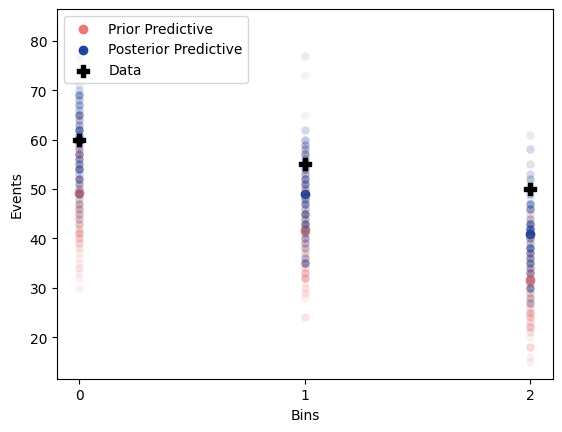

In [53]:
plotting.prior_posterior_predictives(model=model, data=data, post_pred=post_pred, prior_pred=prior_pred, bin_steps=1)

## Model 3

Multiple parameters.

In [101]:
### Simple pyhf model
model = pyhf.Model(
    {'channels': [{'name': 'singlechannel',
    'samples': [
    {'name': 'signal',
     'data': [15, 10, 5],
     'modifiers': [
         {'name': 'mu', 'type': 'normfactor', 'data': None},
         {'name': 'mu2', 'type': 'normfactor', 'data': None}
        ]},

    {'name': 'background',
     'data': [120, 110, 100],
     'modifiers': [
        # Staterror / Normal
        {"name": "my_staterror","type": "staterror","data": [1.1, 1.1, 1.1],},
        # Lumi / Normal
        {'name': 'lumi', 'type': 'lumi', 'data': None},
        # Correlated / Normal
        {'name': 'corr_bkg', 'type': 'histosys','data': {'hi_data': [125, 110, 100] , 'lo_data': [100, 95, 90]}},
        # Uncorrelated / Poisson
        {'name': 'uncorr_bkg', 'type': 'shapesys','data': [12, 11, 10]},
         ]
         },                          
    ]},]
    ,
    "parameters": [
            {
                "name": "lumi",
                "auxdata": [1.0],
                "sigmas": [0.017],
                "bounds": [[0.915, 1.085]],
                "inits": [1.0],
            }],
        }
)

data = [110, 105, 100]


unconstr_priors = {
    'mu_HN': {'type': 'unconstrained_halfnormal', 'input': [[.1]]},
    'mu_Poiss': {'type': 'unconstrained_poisson', 'input': [[5.], [1.]]}
}

prior_dict = prepare_inference.build_priorDict(model, unconstr_priors)


#### Test Stitching

In [143]:
pars = np.array(['unconstr_HN', 'unconstr_poiss', 'norm1', 'norm2', 'norm3', 'norm4', 'norm5', 'gamma1', 'gamma2', 'gamma3'], dtype=object)

prior_dict

{'mu_HN': {'type': 'unconstrained_halfnormal', 'input': [[0.1]]},
 'mu_Poiss': {'type': 'unconstrained_poisson', 'input': [[5.0], [1.0]]},
 'corr_bkg': {'type': 'normal', 'input': [[0.0], [Array(1., dtype=float64)]]},
 'lumi': {'type': 'normal', 'input': [[1.0], [Array(0.017, dtype=float64)]]},
 'my_staterror': {'type': 'normal',
  'input': [[1.0, 1.0, 1.0],
   [Array(0.00916667, dtype=float64),
    Array(0.01, dtype=float64),
    Array(0.011, dtype=float64)]]},
 'uncorr_bkg': {'type': 'poisson',
  'input': [[1000000.0, 1000000.0, 1000000.0],
   [1000000.0, 1000000.0, 1000000.0]]}}

In [144]:
model.config.par_map

{'corr_bkg': {'slice': slice(0, 1, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x2d3f8f640>},
 'lumi': {'slice': slice(1, 2, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x2d3f8f5b0>},
 'mu': {'slice': slice(2, 3, None),
  'paramset': <pyhf.parameters.paramsets.unconstrained at 0x2d29cc1c0>},
 'mu2': {'slice': slice(3, 4, None),
  'paramset': <pyhf.parameters.paramsets.unconstrained at 0x2d29cc190>},
 'uncorr_bkg': {'slice': slice(4, 7, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_poisson at 0x2d29cc640>},
 'my_staterror': {'slice': slice(7, 10, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x2d3ece430>}}

In [141]:
target = prepare_inference.get_target(model)
pars[target.argsort()]

array(['norm1', 'norm2', 'unconstr_HN', 'unconstr_poiss', 'gamma1',
       'gamma2', 'gamma3', 'norm3', 'norm4', 'norm5'], dtype=object)

#### Inference

In [91]:
with infer.model(model, unconstr_priors, data):
    step = pm.Metropolis()
    post_data = pm.sample(draws=100, chains=1, step=step)
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(100)

Only 100 samples in chain.


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 1 seconds.


Sampling: [Expected_Data, Gammas, Normals, Unconstrained_Gamma, Unconstrained_HalfNormal]


In [ ]:
plotting.prior_posterior_predictives(model=model, data=data, post_pred=post_pred, prior_pred=prior_pred, bin_steps=1)

array([[<AxesSubplot: title={'center': 'Normals'}>,
        <AxesSubplot: title={'center': 'Normals'}>],
       [<AxesSubplot: title={'center': 'Unconstrained_HalfNormal'}>,
        <AxesSubplot: title={'center': 'Unconstrained_HalfNormal'}>],
       [<AxesSubplot: title={'center': 'Unconstrained_Gamma'}>,
        <AxesSubplot: title={'center': 'Unconstrained_Gamma'}>],
       [<AxesSubplot: title={'center': 'Gammas'}>,
        <AxesSubplot: title={'center': 'Gammas'}>]], dtype=object)

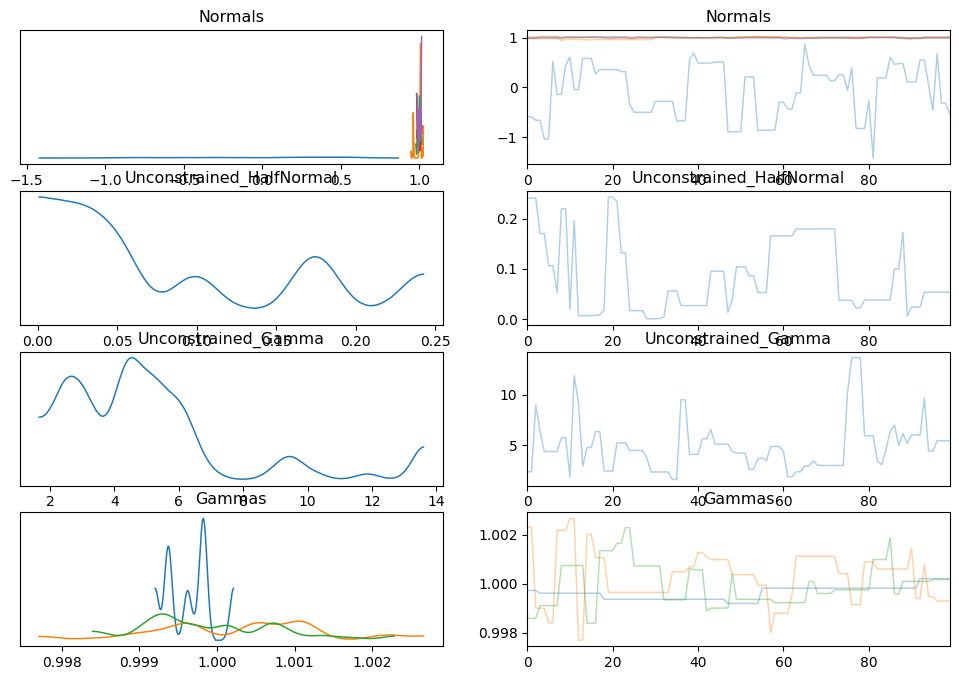

In [142]:
az.plot_trace(post_data)